In [1]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
imm = pd.read_excel('Data/Total_immigration_by_year.xlsx') 
imm.set_index('Year', inplace = True) #set index as year
imm.index= imm.index.astype(str) #change to str for date time format
imm.index = pd.to_datetime(imm.index)
by_year_df = pd.read_csv('pop_all.csv')
by_year_df.index= imm.index
total_immigration = by_year_df['Pop_Perc'].to_frame()
total_immigration.head()

,Pop_Perc
Year,
1820-01-01,0.000872
1821-01-01,0.000922
1822-01-01,0.000678
1823-01-01,0.000606
1824-01-01,0.000733


# Initial Plot of Immigrants as Percentage of US Pop (1820 - 2017)
## World Wars Highlighted and October 29, 1929 (start of GD) Shown

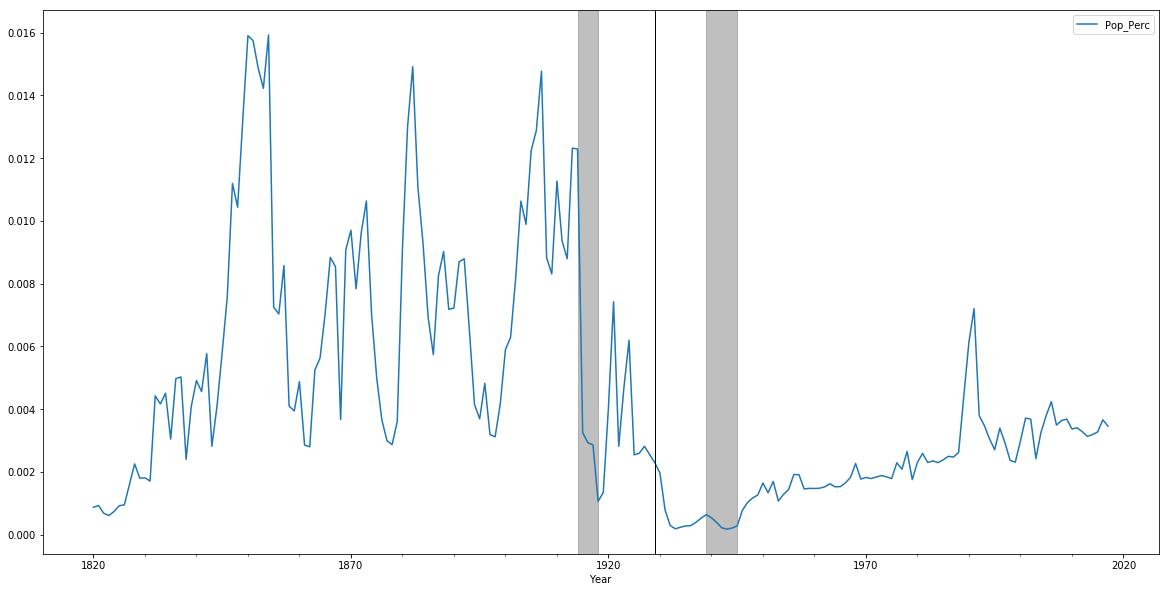

In [3]:
total_immigration.plot(figsize = (20,10))
plt.axvline(pd.to_datetime('1929-10-29'), color='black', linestyle='-', lw=1)

plt.axvspan(pd.to_datetime('1939-09-01'), pd.to_datetime('1945-09-01'), alpha=0.5, color='grey')
plt.axvspan(pd.to_datetime('1914-07-28'), pd.to_datetime('1918-11-11'), alpha=0.5, color='grey')

# Decomposition

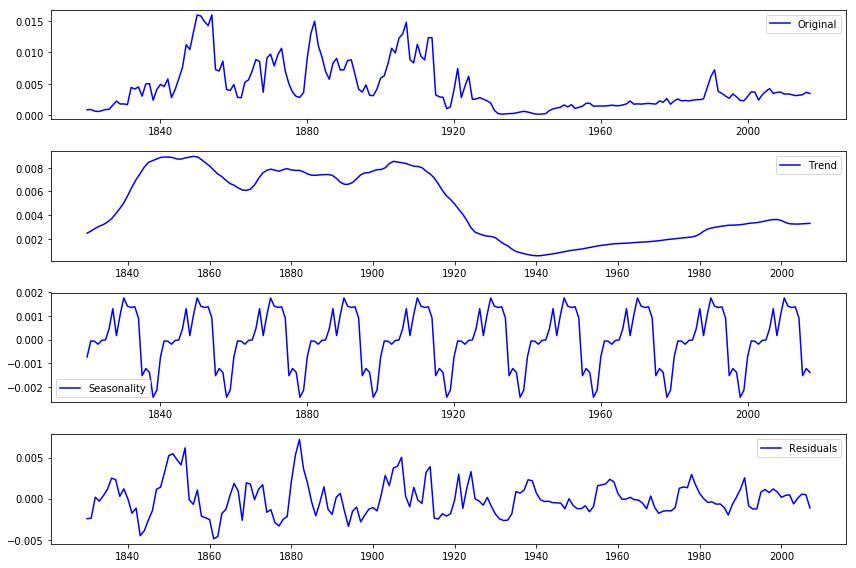

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(total_immigration , freq = 20)  
# decomposition.plot()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(total_immigration, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## Function to check for Stationarity and Graph
### - Rolling Mean and SD with window = 32
### - Plot results of DF Test

In [5]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 32, center = False).mean()
    rolstd = TS.rolling(window = 32, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['Pop_Perc']) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput2['Critical Value (%s)'%key] = value
    print (dfoutput2)

In [6]:
#created a function to quickly process ts for stationarity check function
def clean_for_stat_check(ts):
    ts_df = ts.to_frame()
    ts_df = ts_df.rename(index=str, columns={0:'Number'})
    return ts_df

# Model residuals:

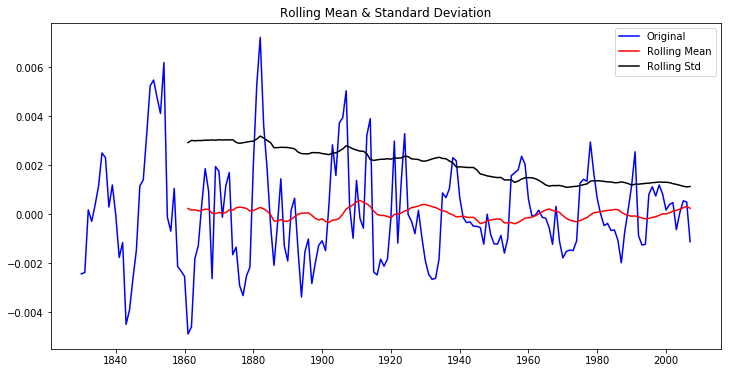

Results of Dickey-Fuller Test:
Test Statistic                -6.643909e+00
p-value                        5.324635e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.700000e+02
Critical Value (1%)           -3.469413e+00
Critical Value (5%)           -2.878696e+00
Critical Value (10%)          -2.575917e+00
dtype: float64


In [7]:

# Drop NaN values from residuals.
decompose = residual
decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(decompose)

The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. So it seems reasonable to assume this time series is stationary.

# Note: Did not do Log transformation because bad pvals from stationarity check file

# Subtracting the rolling mean - this was the winner from the stationarity check/exploration

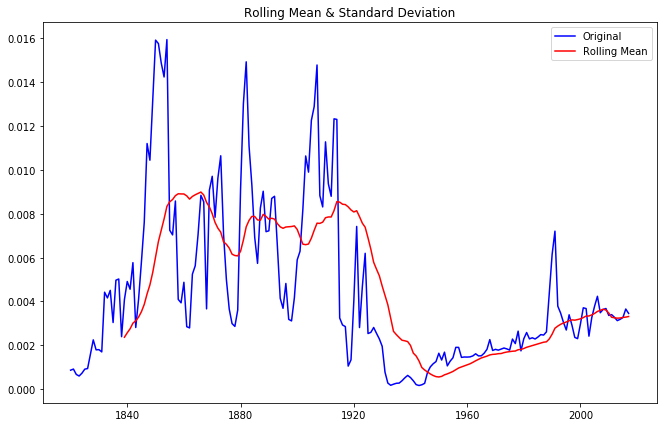

In [8]:
rolmean = total_immigration.rolling(window = 20).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(total_immigration, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [9]:
data_minus_rolmean = total_immigration - rolmean
# data_minus_rolmean.head(15)

In [10]:
data_minus_rolmean.dropna(inplace=True)

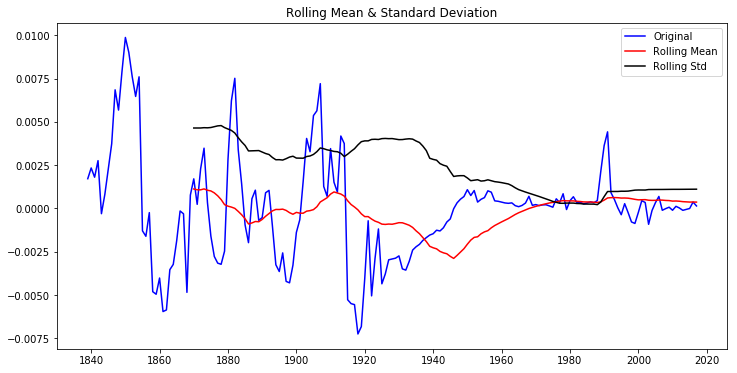

Results of Dickey-Fuller Test:
Test Statistic                  -4.373808
p-value                          0.000330
#Lags Used                       7.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64


In [11]:
stationarity_check(data_minus_rolmean)

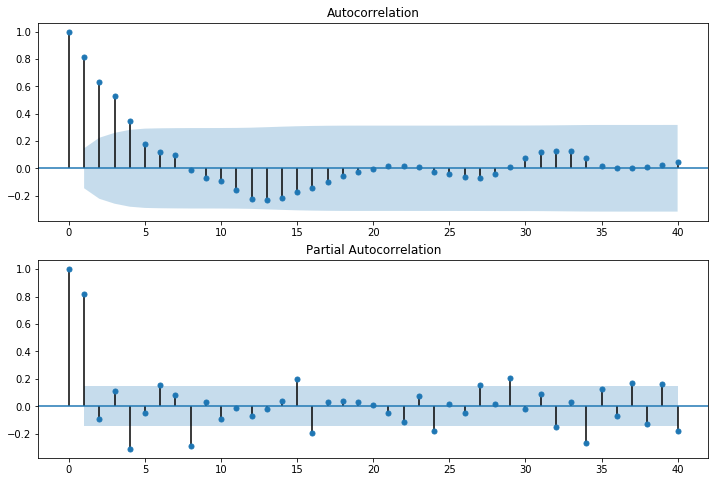

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_minus_rolmean, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_minus_rolmean, lags=40, ax=ax2)

# ER notes 1.22.19: not sure which numbers to use - come back to this once get the best p, q, d values from grid search

In [13]:
mod = sm.tsa.statespace.SARIMAX(data_minus_rolmean, order=(1,0,0), seasonal_order=(0,0,0,12))
results = mod.fit()
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Pop_Perc   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 885.090
Date:                Tue, 22 Jan 2019   AIC                          -1766.180
Time:                        20:18:53   BIC                          -1759.806
Sample:                    01-01-1839   HQIC                         -1763.595
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8158      0.034     23.844      0.000       0.749       0.883
sigma2      2.951e-06   1.94e-07     15.217      0.000    2.57e-06    3.33e-06
===================================================================================
Ljung-Box (Q):                       70.50   Jarque-Bera (JB):               227.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

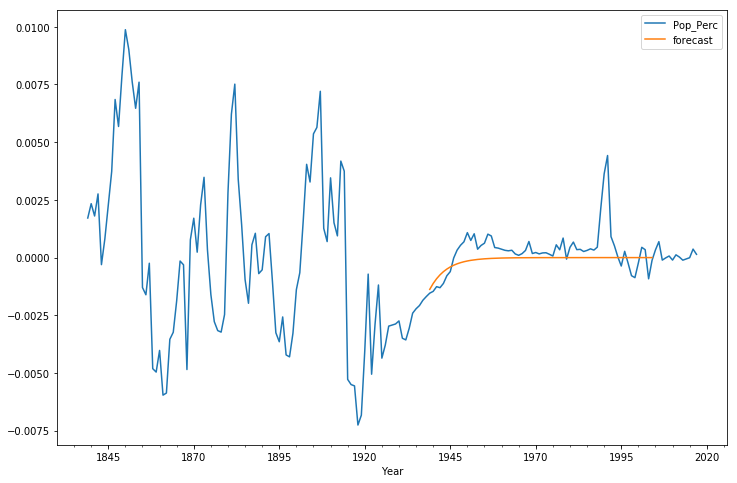

In [14]:
data_minus_rolmean['forecast'] = results.predict(start = 100, end=165, dynamic= True)  
data_minus_rolmean[['Pop_Perc', 'forecast']].plot(figsize=(12, 8))